In [2]:
!pip install smdebug torch torchvision tqdm --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 146.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 201.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 207.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 210.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 176.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 204.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 210.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 213.4 MB/s eta 0:00:00a 0:00:01


In [3]:
pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 723.9/723.9 MB 52.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 82.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:
      Successfully uninstalled torch-1.13.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1
    Uninstalling torchvision-0.14.1:
      Successfully uninstalled torchvision-0.14.1
Note: you may need to restart the kernel to use updated packages.


In [4]:
import sagemaker
import boto3
import os
import json
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import shutil
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs,ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
import time
from PIL import Image
import io
from IPython import display
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
from smdebug.trials import create_trial
from sagemaker.pytorch import PyTorchModel
from smdebug.core.modes import ModeKeys
from sagemaker.predictor import Predictor

[2023-04-07 11:59:11.479 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:77 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [5]:
session = sagemaker.Session()
bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))
region = session.boto_region_name
print("AWS Region: {}".format(region))
role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-002658311351
AWS Region: us-east-1
RoleArn: arn:aws:iam::002658311351:role/service-role/AmazonSageMaker-ExecutionRole-20230329T113772


## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [6]:
path = "train_data"

In [7]:
def download_data(path):
    s3_client = boto3.client('s3')
    with open('file_list.json', 'r') as f:
        d=json.load(f)
    for k, v in d.items():
        print(f"Downloading Images with {k} objects from")
        directory=os.path.join(path, k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

            
download_data(path)

  0%|          | 1/1228 [00:00<02:17,  8.90it/s]

  0%|          | 0/2299 [00:00<?, ?it/s]

  0%|          | 2/2666 [00:00<03:23, 13.11it/s]

  0%|          | 1/2373 [00:00<04:10,  9.46it/s]

  0%|          | 2/1875 [00:00<03:01, 10.35it/s]

100%|██████████| 1875/1875 [03:56<00:00,  7.92it/s]


## Dataset

In [8]:
Main = os.listdir(path)
Main.sort()
Numberofitems = {}
File = {}
for directory in Main:
    File[directory] = [s for s in os.listdir(os.path.join(path, directory)) if "jpg" in s]
    File[directory].sort()
    Numberofitems[directory] = len(File[directory])
    print(f' {Numberofitems[directory]} images in {directory} ')
    print(Numberofitems.keys())


 1228 images in 1 
dict_keys(['1'])
 2299 images in 2 
dict_keys(['1', '2'])
 2666 images in 3 
dict_keys(['1', '2', '3'])
 2373 images in 4 
dict_keys(['1', '2', '3', '4'])
 1875 images in 5 
dict_keys(['1', '2', '3', '4', '5'])


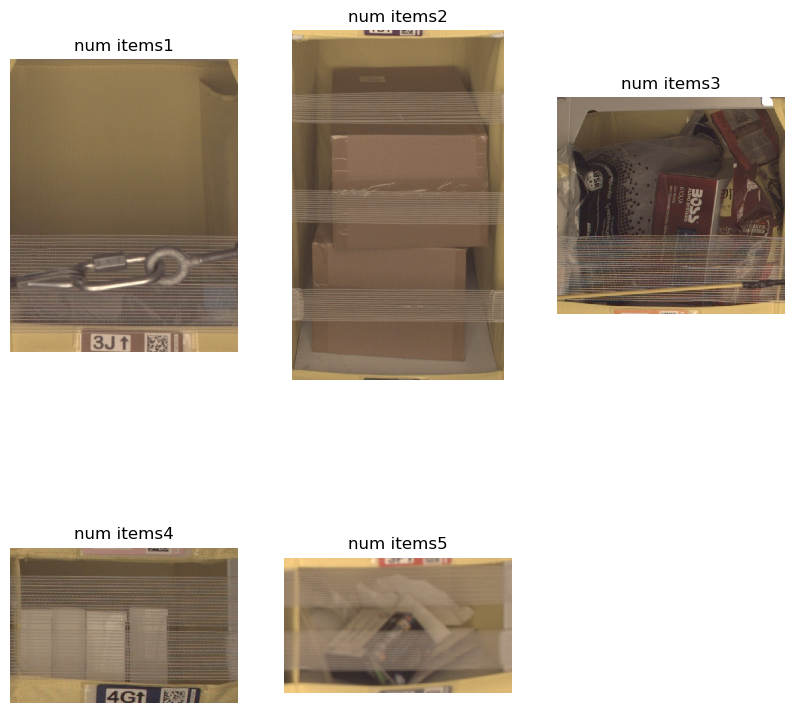

In [9]:
figure = plt.figure(figsize=(10,10))
Columns, Rows = 3, 2
for i in Numberofitems.keys():
    sample_i = random.randint(0, Numberofitems[i]-1)
    img_file_name = File[i][sample_i]
    lb = "num items" +i 
    figure.add_subplot(Rows, Columns, int(i))
    plt.title(lb)
    plt.axis("off")
    plt.imshow(mpimg.imread(os.path.join(path, i, img_file_name)).squeeze(), cmap="gray")
plt.show()
figure.savefig('sample_image.png')

In [10]:
train = {}
test = {}
vald = {}
for i in Numberofitems.keys():
    valid_num = int(0.2*Numberofitems[i])
    test_num = int(0.2*Numberofitems[i])
    train_num =  int(Numberofitems[i] - test_num - valid_num)
    vald[i] = []
    test[i] = []
    train[i] = []
    for X, y in enumerate(File[i]):
        if X < valid_num:
            vald[i].append(y)
        elif (X >= valid_num and X<(test_num+valid_num)):
            test[i].append(y)
        else:
            train[i].append(y)
            
    print(f'num items {i}: Valid: {valid_num}, Test: {test_num}, Train: {train_num}')

num items 1: Valid: 245, Test: 245, Train: 738
num items 2: Valid: 459, Test: 459, Train: 1381
num items 3: Valid: 533, Test: 533, Train: 1600
num items 4: Valid: 474, Test: 474, Train: 1425
num items 5: Valid: 375, Test: 375, Train: 1125


In [11]:
sub_path = 'Data_Div'

try:
    os.mkdir(sub_path)
    os.mkdir(os.path.join(sub_path, 'valid'))
    os.mkdir(os.path.join(sub_path, 'test'))
    os.mkdir(os.path.join(sub_path, 'train'))
except OSError as error:
    print(error)   

for i in Numberofitems.keys():
    try:
        os.mkdir(os.path.join(sub_path, 'valid', i))
        os.mkdir(os.path.join(sub_path, 'test', i))
        os.mkdir(os.path.join(sub_path, 'train', i))
    except OSError as error:
        print(error)
        
    for filename in vald[i]:
        shutil.copy(os.path.join(path, i, filename), os.path.join(sub_path,'valid', i, filename))
    for filename in test[i]:
        shutil.copy(os.path.join(path, i, filename), os.path.join(sub_path,'test', i, filename))
    for filename in train[i]:
        shutil.copy(os.path.join(path, i, filename), os.path.join(sub_path,'train', i, filename))

In [12]:
# Upload dataset to S3
sub_path = 'Data_Div'
bucket_path = "s3://"+ bucket
database_path = os.path.join(bucket_path, sub_path)
print(f"Path to used bucket: {bucket_path}")
print(f"Path to dataset in S3: {database_path}")

os.environ["DATABASE_PATH"] = database_path
os.environ["DATABASE_ORIGIN_PATH"] = sub_path
!aws s3 sync ${DATABASE_ORIGIN_PATH} ${DATABASE_PATH}

Path to used bucket: s3://sagemaker-us-east-1-002658311351
Path to dataset in S3: s3://sagemaker-us-east-1-002658311351/Data_Div
upload: Data_Div/test/1/03410.jpg to s3://sagemaker-us-east-1-002658311351/Data_Div/test/1/03410.jpg
upload: Data_Div/test/1/03516.jpg to s3://sagemaker-us-east-1-002658311351/Data_Div/test/1/03516.jpg
upload: Data_Div/test/1/03401.jpg to s3://sagemaker-us-east-1-002658311351/Data_Div/test/1/03401.jpg
upload: Data_Div/test/1/03416.jpg to s3://sagemaker-us-east-1-002658311351/Data_Div/test/1/03416.jpg
upload: Data_Div/test/1/03442.jpg to s3://sagemaker-us-east-1-002658311351/Data_Div/test/1/03442.jpg
upload: Data_Div/test/1/03569.jpg to s3://sagemaker-us-east-1-002658311351/Data_Div/test/1/03569.jpg
upload: Data_Div/test/1/03440.jpg to s3://sagemaker-us-east-1-002658311351/Data_Div/test/1/03440.jpg
upload: Data_Div/test/1/03545.jpg to s3://sagemaker-us-east-1-002658311351/Data_Div/test/1/03545.jpg
upload: Data_Div/test/1/03565.jpg to s3://sagemaker-us-east-1-0

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [13]:
HP = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32,64, 128]),
}
objective_type = "Minimize"
objective_metric = "Test Loss"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [14]:
os.environ["SM_CHANNEL_TRAINING"] = sub_path
os.environ["SM_MODEL_DIR"] = '.'
!python hp_optimization.py --learning_rate 0.1 --batch_size 32

[2023-04-07 12:24:05.488 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21131 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-04-07 12:24:05.550 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21131 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Arguments: Namespace(batch_size=32, data='Data_Div', learning_rate=0.1, model_dir='.')
HP are LR: 0.1, Batch Size: 32
Data Paths: Data_Div
Starting model Training
Epoch: 0, step train
Epoch 0, Phase train, Images [32/6269 (1%)] Loss: 53.05 Accuracy: 6.0/32 (18.75%)
Epoch 0, Phase train, Images [64/6269 (1%)] Loss: 11040.73 Accuracy: 11.0/64 (17.19%)
Epoch 0, Phase train, Images [96/6269 (2%)] Loss: 10219.58 Accuracy: 21.0/96 (21.88%)
Epoch 0, Phase train, Images [128/6269 (2%)] Loss: 6542.80 Accuracy: 27.0/128 (21.09%)
Epoch 0, Phase train, Images [160/6269 (3%)] Loss: 6871.46 Accuracy: 30.0/160 (18.75%)
Epoch 0, Phase train, Images [1

In [21]:
estimator = PyTorch(
    entry_point="hp_optimization.py",
    base_job_name='Amazon hyperprameter',
    role=role,
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    py_version='py36'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric,
    HP,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=10,
    objective_type=objective_type
)

In [22]:
os.environ["SM_CHANNEL_TRAINING"] = database_path 
os.environ['SM_MODEL_DIR']= bucket_path+ "/model/" 
tuner.fit({"training": database_path})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


................................................................................................................................!


In [23]:
hyperparameter_job = tuner.latest_tuning_job.name
print(hyperparameter_job)

pytorch-training-230407-1244


In [24]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name=hyperparameter_job)

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""128""",0.004488,pytorch-training-230407-1244-010-f817bd13,Completed,0.059746,2023-04-07 12:45:39+00:00,2023-04-07 12:53:23+00:00,464.0
3,"""64""",0.006039,pytorch-training-230407-1244-007-727fa85e,Completed,0.033333,2023-04-07 12:45:20+00:00,2023-04-07 12:52:43+00:00,443.0
1,"""128""",0.002714,pytorch-training-230407-1244-009-565e7f19,Completed,0.032013,2023-04-07 12:45:22+00:00,2023-04-07 12:53:00+00:00,458.0
4,"""64""",0.001218,pytorch-training-230407-1244-006-fbda6815,Completed,0.030311,2023-04-07 12:45:34+00:00,2023-04-07 12:52:47+00:00,433.0
2,"""128""",0.001159,pytorch-training-230407-1244-008-d2bc7752,Completed,0.029594,2023-04-07 12:45:37+00:00,2023-04-07 12:53:15+00:00,458.0
5,"""32""",0.084787,pytorch-training-230407-1244-005-6db18597,Completed,0.006544,2023-04-07 12:45:19+00:00,2023-04-07 12:52:32+00:00,433.0
9,"""32""",0.001010,pytorch-training-230407-1244-001-d2c3a70e,Completed,0.006261,2023-04-07 12:45:13+00:00,2023-04-07 12:52:26+00:00,433.0
7,"""32""",0.003591,pytorch-training-230407-1244-003-b153aabe,Completed,0.005664,2023-04-07 12:45:11+00:00,2023-04-07 12:52:24+00:00,433.0
6,"""32""",0.071463,pytorch-training-230407-1244-004-a034847a,Completed,0.005483,2023-04-07 12:45:20+00:00,2023-04-07 12:52:34+00:00,434.0
8,"""32""",0.001523,pytorch-training-230407-1244-002-c5611e0e,Completed,0.005394,2023-04-07 12:45:16+00:00,2023-04-07 12:52:29+00:00,433.0


In [25]:
best_estimator=tuner.best_estimator()
best_estimator.hyperparameters()


2023-04-07 12:52:31 Starting - Preparing the instances for training
2023-04-07 12:52:31 Downloading - Downloading input data
2023-04-07 12:52:31 Training - Training image download completed. Training in progress.
2023-04-07 12:52:31 Uploading - Uploading generated training model
2023-04-07 12:52:31 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'learning_rate': '0.0015230721261324884',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"Amazon hyperprameter-2023-04-07-12-44-03-832"',
 'sagemaker_program': '"hp_optimization.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-002658311351/Amazon hyperprameter-2023-04-07-12-44-03-832/source/sourcedir.tar.gz"'}

In [27]:
HP = {
    'batch_size': '32',
    'learning_rate': '0.0015230721261324884'
}
HP

{'batch_size': '32', 'learning_rate': '0.0015230721261324884'}

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [28]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
debugger_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [29]:
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1, 
    instance_type="ml.m5.xlarge",
    entry_point="train.py",
    framework_version="1.8",
    py_version='py36',
    hyperparameters=HP,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [30]:
#os.environ["SM_CHANNEL_TRAINING"] = sub_path
#os.environ["SM_MODEL_DIR"] = '.'
#!python train.py --learning_rate 0.1 --batch_size 32

In [31]:
os.environ["SM_CHANNEL_TRAINING"] = database_path # where database is located
os.environ['SM_MODEL_DIR']= bucket_path+ "/model/" # where model will be stored
estimator.fit({"training": database_path}, wait=False)
job_name = estimator._current_job_name
print('Job name:', job_name)
debug_path = estimator.latest_job_debugger_artifacts_path()
print('Debug artifacts path', debug_path)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-04-07-13-17-11-970


Job name: pytorch-training-2023-04-07-13-17-11-970
Debug artifacts path s3://sagemaker-us-east-1-002658311351/pytorch-training-2023-04-07-13-17-11-970/debug-output


In [32]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
desc = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(f'job_name: {job_name}')
print(f'client: {client}')

job_name: pytorch-training-2023-04-07-13-17-11-970
client: <botocore.client.SageMaker object at 0x7fbde40edb50>


In [33]:
%matplotlib inline

while desc["SecondaryStatus"] not in {"Stopped", "Completed", "Failed"}:
    desc = client.describe_training_job(TrainingJobName=job_name)
    prim_status = desc["TrainingJobStatus"]
    sec_status = desc["SecondaryStatus"]
    print("TrainingJobStatus: ", prim_status, " | SecondaryStatus: ", sec_status)
    for r in range(len(estimator.latest_training_job.rule_job_summary())):
        rule_summary = estimator.latest_training_job.rule_job_summary()
        print(
            rule_summary[r]["RuleConfigurationName"], ": ", rule_summary[r]["RuleEvaluationStatus"]
        )
        if rule_summary[r]["RuleEvaluationStatus"] == "IssuesFound":
            print(rule_summary[r]["StatusDetails"])
    print("time now: ", time.asctime())
    display.clear_output(wait=True)
    time.sleep(10) 

TrainingJobStatus:  Completed  | SecondaryStatus:  Completed
VanishingGradient :  InProgress
Overfit :  InProgress
Overtraining :  InProgress
PoorWeightInitialization :  IssuesFound
RuleEvaluationConditionMet: Evaluation of the rule PoorWeightInitialization at step 0 resulted in the condition being met

ProfilerReport :  InProgress
time now:  Fri Apr  7 13:28:16 2023


In [34]:
trial = create_trial(debug_path)

[2023-04-07 13:28:26.323 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:77 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-002658311351/pytorch-training-2023-04-07-13-17-11-970/debug-output
[2023-04-07 13:28:26.755 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:77 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 4747 more expected)', IncompleteRead(0 bytes read, 4747 more expected)) while reading s3://sagemaker-us-east-1-002658311351/pytorch-training-2023-04-07-13-17-11-970/debug-output/index/000000000/000000000000_worker_0.json . Will retry now


In [35]:
print("No of TRAIN datapoints {}".format(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))))
print("No of EVAL datapoints {}".format(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))))

[2023-04-07 13:28:28.585 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:77 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-04-07 13:28:29.604 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:77 INFO trial.py:210] Loaded all steps
No of TRAIN datapoints 60
No of EVAL datapoints 87


In [36]:
def get_the_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plt_tens(trial, tensor_name):

    steps_training, vals_training = get_the_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    steps_evaldation, vals_evaldation = get_the_data(trial, tensor_name, mode=ModeKeys.EVAL)

    fig = plt.figure(figsize=(12, 9))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)
    
    (p1,) = host.plot(steps_training, vals_training, label=tensor_name)
    (p2,) = par.plot(steps_evaldation, vals_evaldation, label="val_" + tensor_name)
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    fig.savefig('debug_values.png')

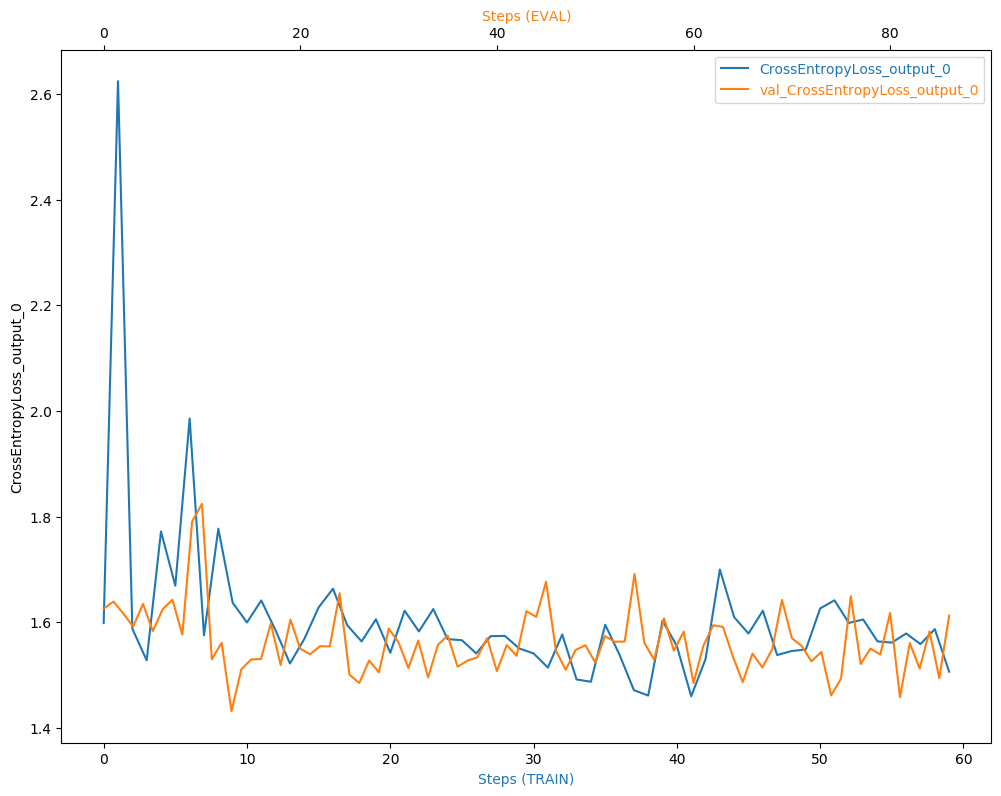

In [37]:
plt_tens(trial, "CrossEntropyLoss_output_0")

In [38]:
model_location=estimator.model_data
print(model_location)

s3://sagemaker-us-east-1-002658311351/pytorch-training-2023-04-07-13-17-11-970/output/model.tar.gz


In [39]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer
        )

In [41]:
pytorch_model = PyTorchModel(model_data=model_location, 
                             role=role, 
                             entry_point='inference.py',
                             py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

INFO:sagemaker:Creating model with name: pytorch-inference-2023-04-07-13-31-54-550
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-04-07-13-31-55-368
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-04-07-13-31-55-368


----!

In [ ]:
from PIL import Image
import io

with open("test_image.jpg", "rb") as image:
    f = image.read()
    img_bytes = bytearray(f)
    Image.open(io.BytesIO(img_bytes))

response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [ ]:
print("Raw prediction result:")
print(response)
print()

labeled_predictions = list(zip(range(133), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))


print(np.argmax(response, 1))
print("Expected answer: 4")

In [43]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-04-07-13-31-55-368
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-04-07-13-31-55-368
